# Experiment 1 

- Fine-tuning of the pre-trained TAPE model in a progressively specialized manner while extending the frozen layers
- Performance evaluation using two external datasets, Shomuradova and ImmuneCODE datatsets, which contain SARS-CoV-2 S-protein <sub>269~-277</sub>(YLQPRTFLL) epitope-specific TCR CDR3βs 

## Training process and model architecture


<img src='res/fig1.png' width='70%'>

Training process for the proposed model. The initial model is cloned from pre-trained Tasks Assessing Protein Embeddings (TAPE) model, adding a classification layer at the end. The pre-trained model is fine-tuned in two rounds in a progressively specialized manner while extending the frozen layers between rounds.

<img src='res/fig2.png' width='30%'>

The proposed model architecture. Input amino acid sequences concatenated by epitope and CDR3β sequences are first encoded into tokens using a tokenizer. Each token is then embedded into a 768-dimensional vector in the pre-trained Tasks Assessing Protein Embeddings (TAPE) model which has 12 encoding layers with 12 self-attention heads in each layer. The final classifier, a 2-layer feed forward network, is then used to predict either binder or not from the output of the TAPE model.

## Global configurations

In [37]:
import logging
import logging.config
import os
import sys
import warnings
from enum import auto
import pandas as pd
import numpy as np
from IPython.core.display import display

rootdir = '/home/hym/trunk/TCRBert'
workdir = '%s/notebook' % rootdir
datadir = '%s/data' % rootdir
srcdir = '%s/tcrbert' % rootdir
outdir = '%s/output' % rootdir

os.chdir(workdir)

sys.path.append(rootdir)
sys.path.append(srcdir)

from tcrbert.exp import Experiment
from tcrbert.predlistener import PredResultRecoder


# Display
pd.set_option('display.max.rows', 2000)
pd.set_option('display.max.columns', 2000)

# Logger
warnings.filterwarnings('ignore')
logging.config.fileConfig('../config/logging.conf')
logger = logging.getLogger('tcrbert')
logger.setLevel(logging.INFO)

# Target experiment
exp_key = 'exp1'
experiment = Experiment.from_key(exp_key)

exp_conf = experiment.exp_conf

display(exp_conf)

2021-11-16 21:56:17 [INFO]: Loaded exp_conf: {'title': 'exp1', 'description': 'Fine-tuning of pre-trained TAPE model in a progressively specialized manner', 'paper': 'exp1', 'model_config': '../config/bert-base/', 'outdir': '../output/exp1', 'train': {'pretrained_model': {'type': 'tape', 'location': '../config/bert-base/'}, 'data_parallel': False, 'backup': 'train.bak.{date}.tar.gz', 'rounds': [{'data': 'dash_vdjdb_mcpas', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 150, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'type': 'adam', 'lr': 0.0001}, 'train_bert_encoders': [-10, None], 'early_stopper': {'monitor': 'accuracy', 'patience': 15}, 'model_checkpoint': {'chk': 'train.{round}.model_{epoch}.chk', 'monitor': 'accuracy', 'save_best_only': True, 'period': 1}, 'result': 'train.{round}.result.json'}, {'data': 'iedb_sars2', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 100, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'type': 'adam', 'lr': 0.0001}, 'train_ber

{'title': 'exp1',
 'description': 'Fine-tuning of pre-trained TAPE model in a progressively specialized manner',
 'paper': 'exp1',
 'model_config': '../config/bert-base/',
 'outdir': '../output/exp1',
 'train': {'pretrained_model': {'type': 'tape',
   'location': '../config/bert-base/'},
  'data_parallel': False,
  'backup': 'train.bak.{date}.tar.gz',
  'rounds': [{'data': 'dash_vdjdb_mcpas',
    'test_size': 0.2,
    'batch_size': 128,
    'n_epochs': 150,
    'n_workers': 12,
    'metrics': ['accuracy'],
    'optimizer': {'type': 'adam', 'lr': 0.0001},
    'train_bert_encoders': [-10, None],
    'early_stopper': {'monitor': 'accuracy', 'patience': 15},
    'model_checkpoint': {'chk': 'train.{round}.model_{epoch}.chk',
     'monitor': 'accuracy',
     'save_best_only': True,
     'period': 1},
    'result': 'train.{round}.result.json'},
   {'data': 'iedb_sars2',
    'test_size': 0.2,
    'batch_size': 128,
    'n_epochs': 100,
    'n_workers': 12,
    'metrics': ['accuracy'],
    'opt

## Fine-tuning results

Populating the interactive namespace from numpy and matplotlib
##############################
n_epochs: 150
stopped_epoch: 66
best_epoch: 51
best_score: 0.7807942708333334
best_chk: ../output/exp1/train.0.model_51.chk
##############################
n_epochs: 100
stopped_epoch: 32
best_epoch: 22
best_score: 0.9235887096774194
best_chk: ../output/exp1/train.1.model_22.chk


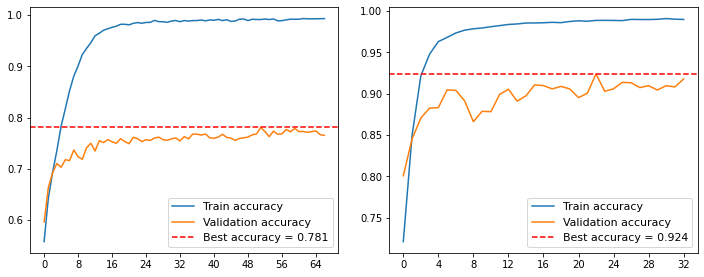

In [97]:
%pylab inline

def show_train_result(train_result=None, ax=None, title=None):
    df = pd.DataFrame({
        'train_loss': train_result['train.score']['loss'],
        'val_loss': train_result['val.score']['loss'],
        'train_accuracy': train_result['train.score']['accuracy'],
        'val_accuracy': train_result['val.score']['accuracy']
    })

    ax = df.loc[:, ['train_accuracy', 'val_accuracy']].plot(ax=ax, title=title)
    bs = train_result['best_score']
    n_epochs = train_result['stopped_epoch']
    ax.axhline(y=bs, ls='--', c='red')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.legend(["Train accuracy", "Validation accuracy", "Best accuracy = %0.3f" % bs], prop={"size": 11})
    
    print('##############################')
    print('n_epochs: %s' % train_result['n_epochs'])
    print('stopped_epoch: %s' % train_result['stopped_epoch'])
    print('best_epoch: %s' % train_result['best_epoch'])
    print('best_score: %s' % train_result['best_score'])
    print('best_chk: %s' % train_result['best_chk'])


fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(4)
plt.tight_layout(h_pad=2, w_pad=2)

show_train_result(train_result=experiment.get_train_result(0), 
                  ax=axes[0])
show_train_result(train_result=experiment.get_train_result(1), 
                  ax=axes[1])


## Loading final fine-tuned model

In [49]:
model = experiment.load_eval_model()
display(model)

# Eval result recoder
eval_recoder = PredResultRecoder(output_attentions=True, output_hidden_states=True)
model.add_pred_listener(eval_recoder)

2021-11-16 21:58:38 [INFO]: Create TAPE model using config: ../config/bert-base/
2021-11-16 21:58:41 [INFO]: Loading the eval model from ../output/exp1/train.1.model_22.chk


BertTCREpitopeModel(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): ProteinBertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm()
              (dropout): Dropout(p=0.1)
            )
     

## Model evaluations

### Shomuradova <i>et al.</i>

- Performance evaluation for the dataset containing COVID-19 S-protein<sub>266-277</sub>(YLQPRTFLL) epitope-specific CDR3βs from  Shomuradova <i>et al.</i>

#### Loading eval dataset

In [50]:
from torch.utils.data import DataLoader
from tcrbert.dataset import TCREpitopeSentenceDataset
import numpy as np
from tcrbert.dataset import CN
from tcrbert.bioseq import write_fa

epitope = 'YLQPRTFLL'

sh_ds = TCREpitopeSentenceDataset.from_key('shomuradova')
sh_df = sh_ds.df_enc

print(sh_ds.name)
display(sh_df.head(), sh_df.shape)
summary_df(sh_df)

shomuradova


epitope epitope_gene epitope_species  \
YLQPRTFLL_CASSFQNTGELFF     YLQPRTFLL        Spike      SARS-CoV-2   
YLQPRTFLL_CASSSVNNNEQFF     YLQPRTFLL        Spike      SARS-CoV-2   
YLQPRTFLL_CAVGEANTGELFF     YLQPRTFLL        Spike      SARS-CoV-2   
YLQPRTFLL_CAYQEVNTGELFF     YLQPRTFLL        Spike      SARS-CoV-2   
YLQPRTFLL_CSARDDQAVNTGELFF  YLQPRTFLL        Spike      SARS-CoV-2   

                                species             cdr3b       mhc  \
YLQPRTFLL_CASSFQNTGELFF     HomoSapiens     CASSFQNTGELFF  HLA-A*02   
YLQPRTFLL_CASSSVNNNEQFF     HomoSapiens     CASSSVNNNEQFF  HLA-A*02   
YLQPRTFLL_CAVGEANTGELFF     HomoSapiens     CAVGEANTGELFF  HLA-A*02   
YLQPRTFLL_CAYQEVNTGELFF     HomoSapiens     CAYQEVNTGELFF  HLA-A*02   
YLQPRTFLL_CSARDDQAVNTGELFF  HomoSapiens  CSARDDQAVNTGELFF  HLA-A*02   

                                 source  label  \
YLQPRTFLL_CASSFQNTGELFF     Shomuradova      1   
YLQPRTFLL_CASSSVNNNEQFF     Shomuradova      1   
YLQPRTFLL_CAVGEANTGELFF     Shomuradova      1   
YLQPRTFLL_CAYQEVNTGELFF     Shomuradova      1   
YLQPRTFLL_CSARDDQAVNTGELFF  Shomuradova      1   

                                                                     sentence  
YLQPRTFLL_CASSFQNTGELFF     [2, 28, 15, 20, 19, 21, 23, 10, 15, 15, 7, 5, ...  
YLQPRTFLL_CASSSVNNNEQFF     [2, 28, 15, 20, 19, 21, 23, 10, 15, 15, 7, 5, ...  
YLQPRTFLL_CAVGEANTGELFF     [2, 28, 15, 20, 19, 21, 23, 10, 15, 15, 7, 5, ...  
YLQPRTFLL_CAYQEVNTGELFF     [2, 28, 15, 20, 19, 21, 23, 10, 15, 15, 7, 5, ...  
YLQPRTFLL_CSARDDQAVNTGELFF  [2, 28, 15, 20, 19, 21, 23, 10, 15, 15, 7, 22,...

(610, 9)

Epitope species Epitope gene    Epitope       MHC  Samples  Positives
0      SARS-CoV-2        Spike  YLQPRTFLL  HLA-A*02      610        305

#### Performance evaluation for Shomuradova dataset

Populating the interactive namespace from numpy and matplotlib
2021-11-16 21:58:51 [INFO]: ======================
2021-11-16 21:58:51 [INFO]: Begin predict...
2021-11-16 21:58:51 [INFO]: use_cuda, device: False, cpu
2021-11-16 21:58:51 [INFO]: n_data: 610
2021-11-16 21:58:51 [INFO]: batch_size: 610
2021-11-16 21:58:51 [INFO]: [PredResultRecoder]: on_predict_begin...
2021-11-16 21:58:51 [INFO]: Begin 0/1 prediction batch
2021-11-16 21:59:13 [INFO]: End 0/1 prediction batch
2021-11-16 21:59:13 [INFO]: [PredResultRecoder]: on_predict_end...
2021-11-16 21:59:16 [INFO]: Done to predict...
2021-11-16 21:59:16 [INFO]: ======================
score_map: OrderedDict([('accuracy', 0.9426229508196722), ('f1', 0.942339373970346), ('roc_auc', 0.980462241332975)])


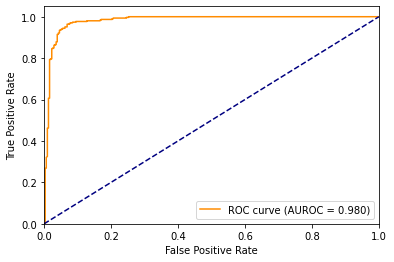

In [51]:
%pylab inline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import numpy as np

metrics = ['accuracy', 'f1', 'roc_auc']

data_loader = DataLoader(sh_ds, batch_size=len(sh_ds), shuffle=False, num_workers=2)
model.predict(data_loader=data_loader, metrics=metrics)
print('score_map: %s' % eval_recoder.result_map['score_map'])

input_labels  = np.array(eval_recoder.result_map['input_labels'])
output_labels = np.array(eval_recoder.result_map['output_labels'])
output_probs  = np.array(eval_recoder.result_map['output_probs'])

fpr, tpr, _ = roc_curve(input_labels, output_probs)
score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUROC = %0.3f)' % score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")



# Epitope-specific ROC curves
# epitopes = sh_df[CN.epitope].unique()

# fig, axes = plt.subplots(nrows=epitopes.shape[0], ncols=1)
# fig.set_figwidth(5)
# fig.set_figheight(4*len(epitopes))
# plt.tight_layout(h_pad=5, w_pad=3)

# for i, epitope in enumerate(epitopes):
#     indices = np.where(sh_df[CN.epitope] == epitope)[0]
# #     title = '%s-specific CDR3βs' % epitope
#     print(indices, len(indices))
#     title = None
#     ax = axes[i] if epitopes.shape[0] > 1 else axes
#     show_roc_curve(input_labels[indices], output_probs[indices], title=title, ax=ax)

#### Investigating position-wise attention weights 

##### Selecting target CDR3β sequences with most common lengths and predicted as a binder

Populating the interactive namespace from numpy and matplotlib
cum_ratio: 159/302=0.5264900662251656
target_indices for 13: [  0   1   2   3   5   7   9  11  13  15  18  19  20  21  22  23  24  25
  27  32  33  35  37  38  39  43  51  52  57  59  62  65  67  70  71  72
  74  75  76  78  79  81  82  88  89  90  91  92  93  94  97  99 100 110
 111 113 115 117 118 119 120 122 123 124 127 129 134 138 139 142 146 147
 149 150 153 154 155 156 158 160 161 162 166 168 169 170 172 173 174 175
 176 177 178 179 180 185 186 188 189 190 192 193 194 197 198 201 202 203
 207 211 213 217 219 220 223 225 228 231 232 233 234 235 237 238 239 240
 243 244 245 247 250 251 252 254 256 260 261 263 266 267 268 270 271 273
 275 277 279 280 287 289 290 291 292 294 295 296 298 299 533](159)
cum_ratio: 221/302=0.7317880794701986
target_indices for 16: [  4  29  34  40  41  42  44  53  56  60  61  63  83  96 103 105 106 107
 108 112 114 121 132 133 157 164 165 167 171 182 184 191 199 200 204 208
 212 215 216 224 2

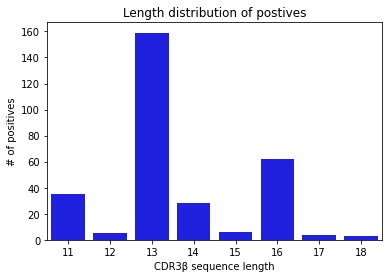

In [52]:
%pylab inline

import matplotlib.pyplot as plt
import matplotlib.image as image

import seaborn as sns
from collections import Counter, OrderedDict

pos_indices = np.where(output_labels == 1)[0]
# print('pos_indices: %s(%s)' % (pos_indices, str(pos_indices.shape)))
pos_cdr3b = sh_df[CN.cdr3b].values[pos_indices]

##########################################
lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), pos_cdr3b)).items()))
lens = np.array(lens)
cnts = np.array(cnts)
ax = sns.barplot(x=lens, y=cnts, color='blue')
ax.set_title('Length distribution of postives')
ax.set_xlabel('CDR3β sequence length')
ax.set_ylabel('# of positives')

# Select target indices by cdr3b sequence lenghts
target_index_map = OrderedDict()
order = np.argsort(cnts)[::-1]
cum_cnt = 0
for cur_len, cur_cnt in zip(lens[order], cnts[order]):
    cum_cnt += cur_cnt
    cum_ratio = cum_cnt/pos_indices.shape[0]
    print('cum_ratio: %s/%s=%s' % (cum_cnt, pos_indices.shape[0], cum_ratio))
    if cum_ratio < 0.9:
        target_indices = np.where((output_labels == 1) & (sh_df[CN.cdr3b].map(lambda x: len(x) == cur_len)))[0]
        print('target_indices for %s: %s(%s)' % (cur_len, target_indices, target_indices.shape[0]))
        target_index_map[cur_len] = target_indices



##### Marginalized position-wise attention weights for target YLQPRTFLL-CDR3b sequences 

- The output attention weights have the dimension $(L, N, H, S, S)$, where $L$ is the number of encoding layers, $N$ is the number of YLQPRTFLL-CDR3β sequence pairs, $H$ is the number of attention heads, and $S$ is the fixed-length of the sequences. The attention weights were marginalized into a one-dimensional vector of length of $S$. A value of the vector at the position $m$, $Am$ is given by the following equation:

<img src='res/eq1.png' width='50%'>

Populating the interactive namespace from numpy and matplotlib
attentions.shape: (12, 610, 12, 40, 40)
Attention weights for 13: [0.01910887 0.0179613  0.01973714 0.02477849 0.01948013 0.01740976
 0.01900532 0.01822388 0.01893266 0.02441667 0.01896947 0.02572736
 0.02743797 0.04475417 0.04124944 0.04041077 0.03960473 0.03146686
 0.0290944  0.02959589 0.02391365 0.026086  ]
Attention weights for 16: [0.01880863 0.01630818 0.01778503 0.02330432 0.01905179 0.01686901
 0.01948565 0.01802048 0.01873603 0.02190986 0.01850647 0.02340156
 0.02902398 0.04218578 0.04262356 0.03521042 0.03835867 0.04506871
 0.03318812 0.02880196 0.02597458 0.02519257 0.02197142 0.02124949
 0.02519121]
Attention weights for 11: [0.01851932 0.01812305 0.02129371 0.02367177 0.01928474 0.01703554
 0.0200285  0.0179186  0.01996592 0.02376263 0.02014127 0.02324174
 0.02296821 0.03928088 0.04920531 0.0431544  0.0341846  0.03139623
 0.02781255 0.03191699]


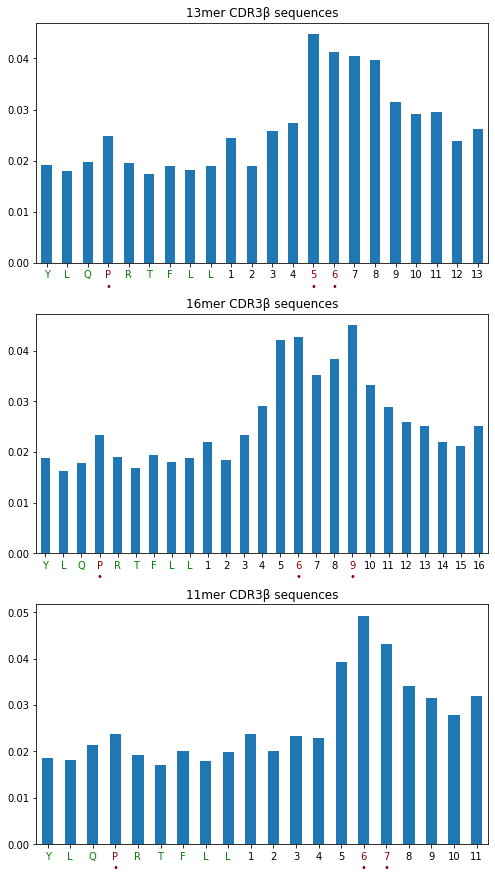

In [53]:
%pylab inline

# n_layers = model.config.num_hidden_layers
# n_data = len(eval_ds)
# n_heads = model.config.num_attention_heads
# max_len = eval_ds.max_len

epitope_len = len(epitope)

attentions = eval_recoder.result_map['attentions']
# attentions.shape: (n_layers, n_data, n_heads, max_len, max_len)
print('attentions.shape: %s' % str(attentions.shape))

# target_attn_map = OrderedDict()

fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_figwidth(7)
fig.set_figheight(12)
plt.tight_layout(h_pad=3, w_pad=3)

for i, (cur_len, cur_indices) in enumerate(target_index_map.items()):
    attns = attentions[:, cur_indices]
    sent_len = epitope_len + cur_len
    
    # Position-wise marginal attentions by mean
    attns = np.mean(attns, axis=(0, 1, 2, 3))[1:sent_len+1]
    print('Attention weights for %s: %s' % (cur_len, attns))
    
    ax = pd.Series(attns).plot(kind='bar', ax=axes[i], rot=0)
    ax.set_title('%smer CDR3β sequences' % cur_len)

    ticks = list(epitope) + list(range(1, cur_len + 1))
    mark_ratio = 0.1
    mark_pos = []

    for rank, pos in enumerate(np.argsort(attns[:epitope_len])[::-1]):
        if rank < (epitope_len*mark_ratio):
            ticks[pos] = '%s\n•' % (ticks[pos])
            mark_pos.append(pos)

    for rank, pos in enumerate(np.argsort(attns[epitope_len:])[::-1]):
        if rank < (cur_len*mark_ratio):
            ticks[epitope_len+pos] = '%s\n•' % (ticks[epitope_len+pos])
            mark_pos.append(epitope_len+pos)

    ax.set_xticklabels(ticks) 
    for i, tick in enumerate(ax.get_xticklabels()):
        if i < epitope_len:
            tick.set_color('green')
        else:
            tick.set_color('black')
        if i in mark_pos:
            tick.set_color('darkred')

### ImmuneCODE dataset

-  The dataset contained 718 COVID-19 S-protein<sub>269-277</sub>-specific TCRs from the ImmuneRACE study launched by Adaptive Biotechnologies and Microsoft (https://immunerace.adaptivebiotech.com, June 10, 2020 dataset, from hereafter referred to as ImmuneCODE dataset

#### Loading eval dataset

In [54]:
im_ds = TCREpitopeSentenceDataset.from_key('immunecode')
display(im_ds.name, len(im_ds))

# Remove duplicated CDR3beta seqs with Shomuradova
im_ds.df_enc = im_ds.df_enc[
        im_ds.df_enc[CN.cdr3b].map(lambda seq: seq not in sh_df[CN.cdr3b].values)
]
im_df = im_ds.df_enc
print('After removing duplicates, len(im_ds): %s' % len(im_ds))
display(summary_df(im_df), im_df.shape)

'immunecode'

742

After removing duplicates, len(im_ds): 718


Epitope species Epitope gene    Epitope MHC  Samples  Positives
0      SARS-CoV-2        Spike  YLQPRTFLL   -      718        328

(718, 9)

#### Performance evaluation for the ImmuneCODE dataset

Populating the interactive namespace from numpy and matplotlib
2021-11-16 21:59:41 [INFO]: ======================
2021-11-16 21:59:41 [INFO]: Begin predict...
2021-11-16 21:59:41 [INFO]: use_cuda, device: False, cpu
2021-11-16 21:59:41 [INFO]: n_data: 718
2021-11-16 21:59:41 [INFO]: batch_size: 718
2021-11-16 21:59:41 [INFO]: [PredResultRecoder]: on_predict_begin...
2021-11-16 21:59:42 [INFO]: Begin 0/1 prediction batch
2021-11-16 22:00:11 [INFO]: End 0/1 prediction batch
2021-11-16 22:00:12 [INFO]: [PredResultRecoder]: on_predict_end...
2021-11-16 22:00:15 [INFO]: Done to predict...
2021-11-16 22:00:15 [INFO]: ======================
score_map: OrderedDict([('accuracy', 0.9707520891364902), ('f1', 0.9683257918552036), ('roc_auc', 0.9902087242026267)])


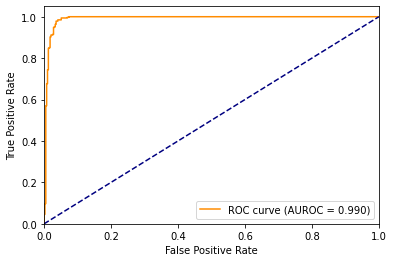

In [55]:
%pylab inline

from sklearn.metrics import roc_curve, auc

data_loader = DataLoader(im_ds, batch_size=len(im_ds), shuffle=False, num_workers=2)
model.predict(data_loader=data_loader, metrics=metrics)

input_labels  = np.array(eval_recoder.result_map['input_labels'])
output_labels = np.array(eval_recoder.result_map['output_labels'])
output_probs  = np.array(eval_recoder.result_map['output_probs'])

fpr, tpr, _ = roc_curve(input_labels, output_probs)
score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUROC = %0.3f)' % score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

print('score_map: %s' % eval_recoder.result_map['score_map'])

#### Investigating position-wise attention weights

##### Selecting target CDR3β sequences with most common lengths and predicted as a binder

Populating the interactive namespace from numpy and matplotlib
cum_ratio: 162/335=0.4835820895522388
target_indices for 13: [  0   2   5   9  10  11  16  17  18  19  21  23  26  27  28  30  32  33
  36  40  41  42  43  44  45  46  47  48  51  55  56  60  63  65  68  69
  71  72  74  75  77  81  84  85  86  87  90  93  94 100 105 106 107 109
 110 111 112 113 114 115 118 126 127 129 131 133 135 138 140 145 147 148
 151 154 156 157 163 166 167 168 170 172 174 175 176 177 181 183 184 188
 190 192 194 196 199 200 201 202 203 204 207 208 209 210 211 216 219 220
 222 223 224 226 230 231 233 234 235 239 247 254 255 256 258 259 260 261
 263 264 265 269 280 281 282 283 286 289 290 292 293 295 297 298 299 304
 306 308 310 312 314 317 318 319 320 321 323 324 325 326 327 406 422 648](162)
cum_ratio: 222/335=0.6626865671641791
target_indices for 14: [  7  22  29  37  39  49  52  53  54  78  82  83  88 101 102 103 104 108
 117 120 121 128 134 136 142 144 150 152 159 160 161 164 178 179 185 186
 193 2

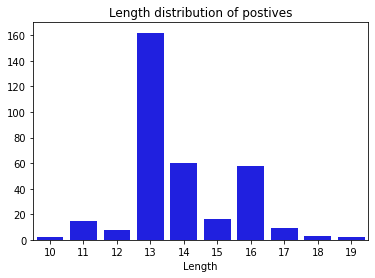

In [56]:
%pylab inline

import matplotlib.pyplot as plt
import matplotlib.image as image

import seaborn as sns
from collections import Counter, OrderedDict

pos_indices = np.where(output_labels == 1)[0]
# print('pos_indices: %s(%s)' % (pos_indices, str(pos_indices.shape)))
pos_cdr3b = im_df[CN.cdr3b].values[pos_indices]

##########################################
lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), pos_cdr3b)).items()))
lens = np.array(lens)
cnts = np.array(cnts)
ax = sns.barplot(x=lens, y=cnts, color='blue')
ax.set_title('Length distribution of postives')
ax.set_xlabel('Length')

# Select target indices by cdr3b sequence lenghts
target_index_map = OrderedDict()
order = np.argsort(cnts)[::-1]
cum_cnt = 0
for cur_len, cur_cnt in zip(lens[order], cnts[order]):
    cum_cnt += cur_cnt
    cum_ratio = cum_cnt/pos_indices.shape[0]
    print('cum_ratio: %s/%s=%s' % (cum_cnt, pos_indices.shape[0], cum_ratio))
    if cum_ratio < 0.85:
        target_indices = np.where((output_labels == 1) & (im_df[CN.cdr3b].map(lambda x: len(x) == cur_len)))[0]
        print('target_indices for %s: %s(%s)' % (cur_len, target_indices, target_indices.shape[0]))
        target_index_map[cur_len] = target_indices


##### Marginalized position-wise attention weights for target YLQPRTFLL-CDR3b sequences 

Populating the interactive namespace from numpy and matplotlib
attentions.shape: (12, 718, 12, 40, 40)
Current attns for 13: [0.01656112 0.01646522 0.02022249 0.02097218 0.01862695 0.01718343
 0.01560583 0.01641221 0.01763443 0.02272799 0.01940311 0.02762335
 0.03012449 0.04839429 0.04504769 0.04432626 0.04259143 0.03211622
 0.03023707 0.03137943 0.0224603  0.02500178]
Current attns for 14: [0.01604391 0.01599983 0.02082858 0.02031975 0.01891712 0.0170706
 0.01600923 0.01614624 0.01754919 0.01931873 0.02231514 0.0255737
 0.03187513 0.04038894 0.04592648 0.05056289 0.04457226 0.04065126
 0.02988513 0.0291209  0.02616752 0.02136733 0.02354312]
Current attns for 16: [0.01620361 0.01487183 0.01840162 0.01970023 0.01804639 0.01689658
 0.01644257 0.01632515 0.01710964 0.01997712 0.01833138 0.02462533
 0.02972515 0.04228593 0.04342785 0.04169411 0.04379743 0.04711964
 0.03700148 0.03179613 0.02709892 0.02510061 0.02230474 0.01970927
 0.02342939]


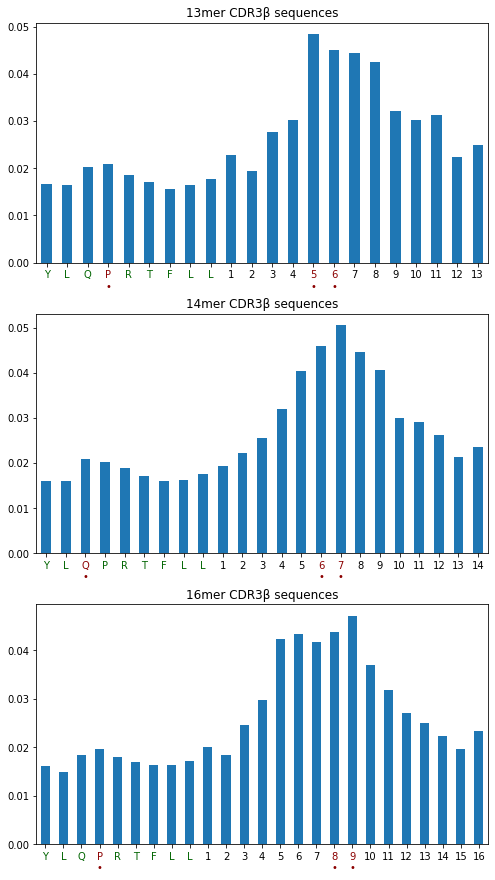

In [57]:
%pylab inline

# n_layers = model.config.num_hidden_layers
# n_data = len(eval_ds)
# n_heads = model.config.num_attention_heads
# max_len = eval_ds.max_len

epitope_len = len(epitope)

attentions = eval_recoder.result_map['attentions']
# attentions.shape: (n_layers, n_data, n_heads, max_len, max_len)
print('attentions.shape: %s' % str(attentions.shape))

# target_attn_map = OrderedDict()

fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_figwidth(7)
fig.set_figheight(12)
plt.tight_layout(h_pad=3, w_pad=3)

for i, (cur_len, cur_indices) in enumerate(target_index_map.items()):
    attns = attentions[:, cur_indices]
    sent_len = epitope_len + cur_len
    
    # Position-wise marginal attentions by mean
    attns = np.mean(attns[-10:], axis=(0, 1, 2, 3))[1:sent_len+1]
    print('Current attns for %s: %s' % (cur_len, attns))
    
    ax = pd.Series(attns).plot(kind='bar', ax=axes[i], rot=0)
    ax.set_title('%smer CDR3β sequences' % cur_len)

    ticks = list(epitope) + list(range(1, cur_len + 1))
    mark_ratio = 0.1
    mark_pos = []

    for rank, pos in enumerate(np.argsort(attns[:epitope_len])[::-1]):
        if rank < (epitope_len*mark_ratio):
            ticks[pos] = '%s\n•' % (ticks[pos])
            mark_pos.append(pos)

    for rank, pos in enumerate(np.argsort(attns[epitope_len:])[::-1]):
        if rank < (cur_len*mark_ratio):
            ticks[epitope_len+pos] = '%s\n•' % (ticks[epitope_len+pos])
            mark_pos.append(epitope_len+pos)

    ax.set_xticklabels(ticks) 
    for i, tick in enumerate(ax.get_xticklabels()):
        if i < epitope_len:
            tick.set_color('darkgreen')
        else:
            tick.set_color('black')
        if i in mark_pos:
            tick.set_color('darkred')
    
